## Political Alignment and Other Views

This is the fourth in a series of notebooks that make up a [case study in exploratory data analysis](https://allendowney.github.io/PoliticalAlignmentCaseStudy/). This case study is part of the [*Elements of Data Science*](https://allendowney.github.io/ElementsOfDataScience/) curriculum.

In previous notebooks, we looked at changes in political alignment over time, and explored the relationship between political alignment and survey questions related to "outlook".

The analysis in this notebook follows the steps we have seen:

1. For your variable of interest, you will read the code book to understand the question and valid responses.
2. You will compute and display the distribution (PMF) of responses and the distribution within each political group.
3. You will recode the variable on a numerical scale that makes it possible to interpret the mean, and then plot the mean over time.
4. You will use a pivot table to compute the mean of your variable over time for each political alignment group (liberal, moderate, and conservative).
5. Finally, you will look at results from three resamplings of the data to see whether the patterns you observed might be due to random sampling.

The following cells define functions from previous notebooks we will use again.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from empiricaldist import Pmf

In [2]:
def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        plt.legend()

In [3]:
from statsmodels.nonparametric.smoothers_lowess import lowess


def make_lowess(series):
    """Use LOWESS to compute a smooth line.

    series: pd.Series

    returns: pd.Series
    """
    y = series.values
    x = series.index.values

    smooth = lowess(y, x)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index)

In [4]:
def plot_series_lowess(series, color):
    """Plots a series of data points and a smooth line.

    series: pd.Series
    color: string or tuple
    """
    series.plot(linewidth=0, marker="o", color=color, alpha=0.5)
    smooth = make_lowess(series)
    smooth.plot(label="_", color=color)

In [5]:
def plot_columns_lowess(table, columns, color_map):
    """Plot the columns in a DataFrame.

    table: DataFrame with a cross tabulation
    columns: list of column names, in the desired order
    color_map: mapping from column names to color_map
    """
    for col in columns:
        series = table[col]
        plot_series_lowess(series, color_map[col])

### Loading the data

In the first notebook, we downloaded GSS data, loaded and cleaned it, resampled it to correct for stratified sampling, and then saved the data in an HDF5 file, which is much faster to load. Now we'll load it.

In [6]:
datafile = "../data/gss_pacs_2022_resampled.hdf"
gss = pd.read_hdf(datafile, "gss0")
gss.shape

(72390, 207)

### Changes in social attitudes

The General Social Survey includes questions about a variety of social attitudes and beliefs. We can use this dataset to explore changes in the responses over time and the relationship with political alignment.

In our subset of the GSS data, we selected questions that were asked repeatedly over the interval of the survey.

To follow the process demonstrated in this notebook, you should choose a variable that you think might be interesting.

If you are not sure which variable to explore, here is a [random selection of three that you can choose from](https://en.wikipedia.org/wiki/The_Paradox_of_Choice):

In [8]:
cols = list(gss.columns)
for col in ["id", "year", "ballot", "age", "sex", "race"]:
    cols.remove(col)

np.random.shuffle(cols)
for col in cols[:3]:
    print(col)

sibs
natcrime
satfin


Fill in the name of the variable you choose below, and select a column.

The variable I'll use as an example is `homosex`, which contains responses to this question (see https://gssdataexplorer.norc.org/variables/634/vshow):

> What about sexual relations between two adults of the same sex--do you think it is always wrong, almost always wrong, wrong only sometimes, or not wrong at all?

In [11]:
varname = "homosex"
column = gss[varname]
column.tail()

72385    4.0
72386    NaN
72387    1.0
72388    NaN
72389    NaN
Name: homosex, dtype: float64

#### Responses

Here's the distribution of responses:

In [12]:
column.value_counts(dropna=False).sort_index()

homosex
1.0    24856
2.0     1857
3.0     2909
4.0    12956
5.0       94
NaN    29718
Name: count, dtype: int64

Then fill in the following cell with the responses and their labels.

In [ ]:
responses = [1, 2, 3, 4, 5]
labels = [
    "Always wrong",
    "Almost always wrong",
    "Sometimes wrong",
    "Not at all wrong",
    "Other",
]

And here's what the distribution looks like. We can use `plt.xticks` to label the x-axis and rotate the labels.

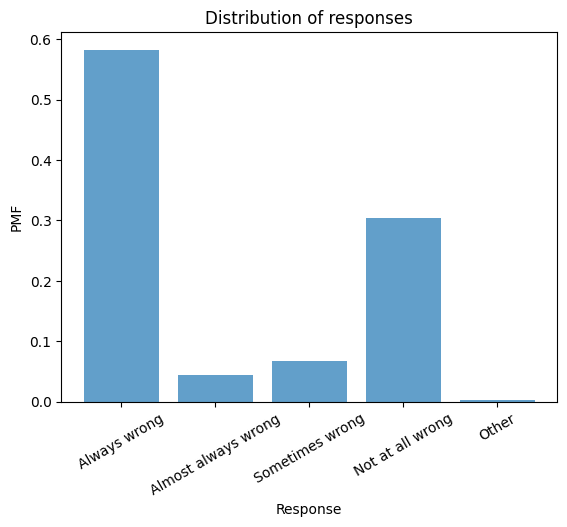

In [35]:
pmf = Pmf.from_seq(column)
pmf.bar(alpha=0.7)

decorate(xlabel="Response", ylabel="PMF", title="Distribution of responses")

plt.xticks(responses, labels, rotation=30)
None

Remember that these results are an average over the entire interval of the survey, so you should not interpret it as a current condition.

#### Responses over time

If we make a cross tabulation of `year` and the variable of interest, we get the distribution of responses over time.

In [15]:
xtab = pd.crosstab(gss["year"], column, normalize="index")

In [16]:
xtab.head()

homosex,1.0,2.0,3.0,4.0,5.0
year,,,,,
1973,0.724066,0.057400,0.082988,0.112725,0.022822
1974,0.709972,0.047051,0.073736,0.126404,0.042837
1976,0.679806,0.057400,0.089212,0.173582,0.000000
1977,0.729767,0.062414,0.071331,0.136488,0.000000
1980,0.725772,0.055994,0.058148,0.160086,0.000000


In [17]:
xtab.tail()

homosex,1.0,2.0,3.0,4.0,5.0
year,,,,,
2014,0.388069,0.029520,0.077491,0.504920,0.0
2016,0.379444,0.036667,0.075000,0.508889,0.0
2018,0.332471,0.034282,0.057568,0.575679,0.0
2021,0.259203,0.040607,0.069829,0.630361,0.0
2022,0.276530,0.031704,0.061207,0.630559,0.0


Now we can plot the results.

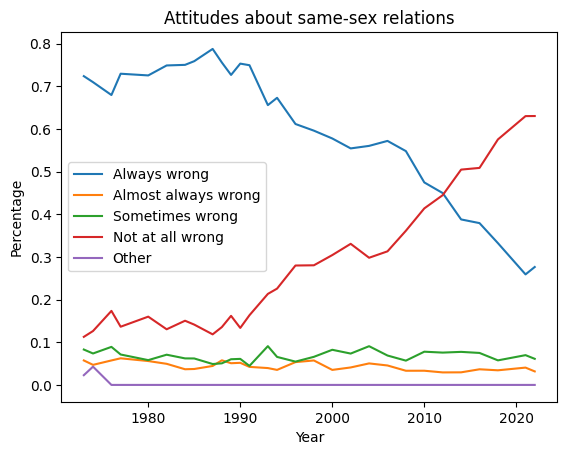

In [18]:
for response, label in zip(responses, labels):
    xtab[response].plot(label=label)

decorate(xlabel="Year", ylabel="Percentage", title="Attitudes about same-sex relations")

This visualization useful for exploring the data, but I would not present this version to an audience.

### Political alignment

To explore the relationship between this variable and political alignment, I'll recode political alignment into three groups:

In [ ]:
d_polviews = {
    1: "Liberal",
    2: "Liberal",
    3: "Liberal",
    4: "Moderate",
    5: "Conservative",
    6: "Conservative",
    7: "Conservative",
}

I'll use `replace` and store the results as a new column in the DataFrame.

In [20]:
gss["polviews3"] = gss["polviews"].replace(d_polviews)

With this scale, there are roughly the same number of people in each group.

In [22]:
gss["polviews3"].value_counts(dropna=False)

polviews3
Moderate        24157
Conservative    21573
Liberal         17203
NaN              9457
Name: count, dtype: int64

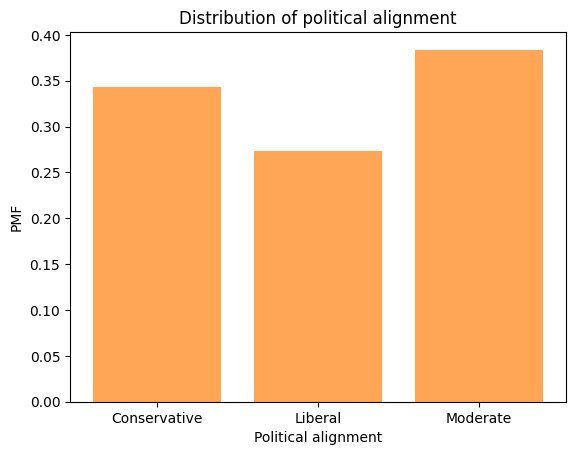

In [ ]:
pmf = Pmf.from_seq(gss["polviews3"])
pmf.bar(color="C1", alpha=0.7)

decorate(
    xlabel="Political alignment",
    ylabel="PMF",
    title="Distribution of political alignment",
)

#### Group by political alignment

Now we can use `groupby` to group the respondents by political alignment.

In [24]:
by_polviews = gss.groupby("polviews3")
by_polviews

Next I will plot the distribution of responses in each group.

But first we'll make a dictionary that maps from each group to a color.

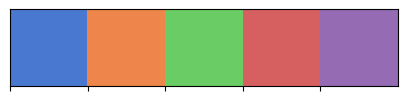

In [25]:
muted = sns.color_palette("muted", 5)
sns.palplot(muted)

In [26]:
color_map = {"Conservative": muted[3], "Moderate": muted[4], "Liberal": muted[0]}

Now we'll make a PMF of responses for each group.

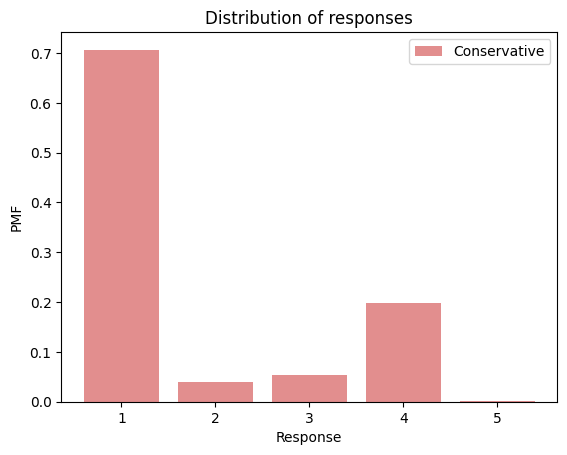

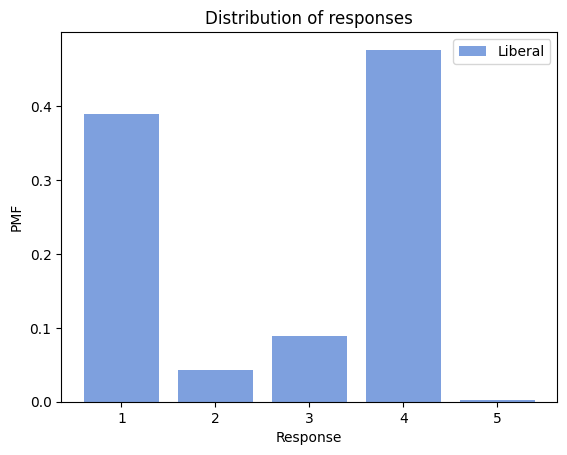

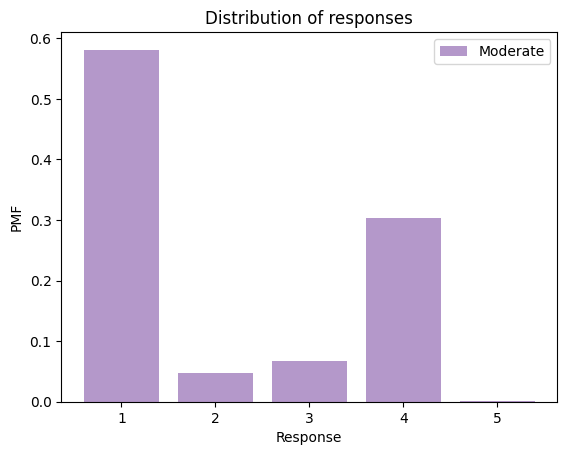

In [28]:
for name, group in by_polviews:
    plt.figure()
    pmf = Pmf.from_seq(group[varname])
    pmf.bar(label=name, color=color_map[name], alpha=0.7)

    decorate(xlabel="Response", ylabel="PMF", title="Distribution of responses")

But again, these results are an average over the interval of the survey, so you should not interpret them as a current condition.

### Recode

For each group, we could compute the mean of the responses, but it would be hard to interpret. So we'll recode the variable of interest to make the mean more... meaningful.

For the variable I chose, a majority of respondents chose "always wrong". I'll use that as my baseline response with code 1, and lump and the other responses with code 0.

We can use `replace` to recode the values and store the result as a new column in the DataFrame.

In [ ]:
d_recode = {1: 1, 2: 0, 3: 0, 4: 0, 5: 0}
gss["recoded"] = column.replace(d_recode)
gss["recoded"].name = varname

And we'll use `value_counts` to check whether it worked.

In [30]:
gss["recoded"].value_counts(dropna=False)

homosex
NaN    29718
1.0    24856
0.0    17816
Name: count, dtype: int64

If we compute the mean, we can interpret it as "the fraction os respondents who think same-sex sexual are always wrong".

NOTE: `Series.mean` drops NaN values before computing the mean.

In [31]:
gss["recoded"].mean()

np.float64(0.5824896887889014)

#### Average by group

Now we can compute the mean of the recoded variable in each group.

In [32]:
means = by_polviews["recoded"].mean()
means

polviews3
Conservative    0.706618
Liberal         0.389347
Moderate        0.581181
Name: homosex, dtype: float64

To get the values in a particular order, we can use the group names as an index:

In [33]:
names = ["Conservative", "Moderate", "Liberal"]
means[names]

polviews3
Conservative    0.706618
Moderate        0.581181
Liberal         0.389347
Name: homosex, dtype: float64

Now we can make a bar plot with color-coded bars:

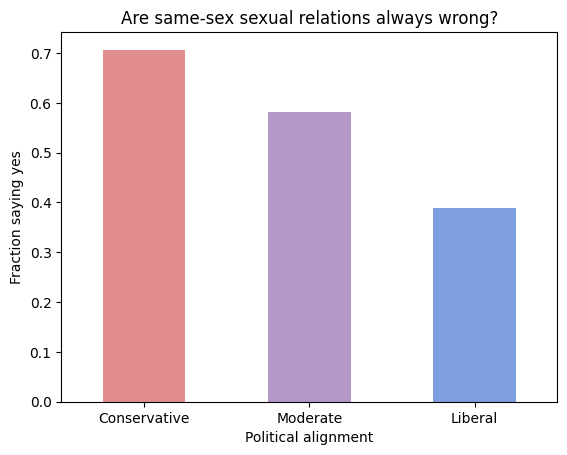

In [ ]:
colors = color_map.values()

means[names].plot(kind="bar", color=colors, alpha=0.7, label="")

decorate(
    xlabel="Political alignment",
    ylabel="Fraction saying yes",
    title="Are same-sex sexual relations always wrong?",
)

plt.xticks(rotation=0)
None

As we might expect, more conservatives think homosexuality is "always wrong", compared moderates and liberals.

### Time series

We can use `groupby` to group responses by year.

In [36]:
by_year = gss.groupby("year")

From the result we can select the recoded variable and compute the mean.

In [37]:
time_series = by_year["recoded"].mean()

And we can plot the results with the data points themselves as circles and a local regression model as a line.

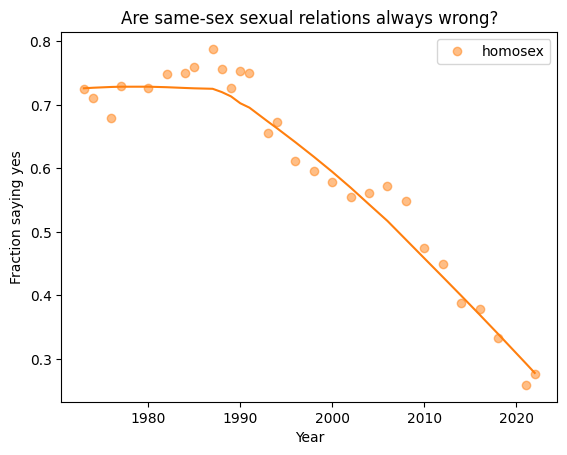

In [ ]:
plot_series_lowess(time_series, "C1")

decorate(
    xlabel="Year",
    ylabel="Fraction saying yes",
    title="Are same-sex sexual relations always wrong?",
)

The fraction of respondents who think homosexuality is wrong has been falling steeply since about 1990.

### Time series by group

So far, we have grouped by `polviews3` and computed the mean of the variable of interest in each group.

Then we grouped by `year` and computed the mean for each year.

Now we'll use `pivot_table` to compute the mean in each group for each year.

In [40]:
table = gss.pivot_table(
    values="recoded", index="year", columns="polviews3", aggfunc="mean"
)

In [41]:
table.head()

polviews3,Conservative,Liberal,Moderate
year,,,
1974,0.795620,0.546512,0.767892
1976,0.775000,0.489848,0.716698
1977,0.823666,0.564165,0.769772
1980,0.834906,0.539130,0.740171
1982,0.801126,0.599198,0.811820


The result is a table that has years running down the rows and political alignment running across the columns.

Each entry in the table is the mean of the variable of interest for a given group in a given year.

#### Plotting the results

Now we can use the `plot_columns_lowess` to see the results.

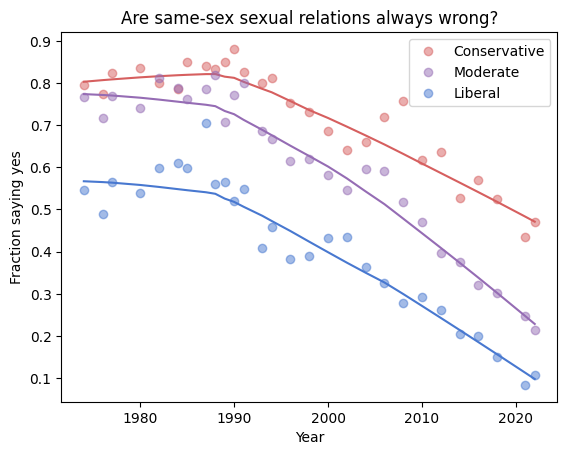

In [ ]:
columns = ["Conservative", "Moderate", "Liberal"]
plot_columns_lowess(table, columns, color_map)

decorate(
    xlabel="Year",
    ylabel="Fraction saying yes",
    title="Are same-sex sexual relations always wrong?",
)

Negative attitudes about homosexuality have been declining in all three groups, starting at about the same time, and at almost the same rate.

### Resampling

The figures we have generated so far in this notebook are based on a single resampling of the GSS data. Some of the features we see in these figures might be due to random sampling rather than actual changes in the world.

By generating the same figures with different resampled datasets, we can get a sense of how much variation there is due to random sampling.

To make that easier, the following function contains the code from the previous analysis all in one place.

You will probably have to update this function with any changes you made in my code.

In [43]:
def plot_by_polviews(gss, varname):
    """Plot mean response by polviews and year.

    gss: DataFrame
    varname: string column name
    """
    gss["polviews3"] = gss["polviews"].replace(d_polviews)

    column = gss[varname]
    gss["recoded"] = column.replace(d_recode)

    table = gss.pivot_table(
        values="recoded", index="year", columns="polviews3", aggfunc="mean"
    )

    columns = ["Conservative", "Moderate", "Liberal"]
    plot_columns_lowess(table, columns, color_map)

    decorate(
        xlabel="Year",
        ylabel="Fraction saying yes",
        title="Are same-sex relations always wrong?",
    )

Now we can loop through the three resampled datasets and generate a figure for each one.

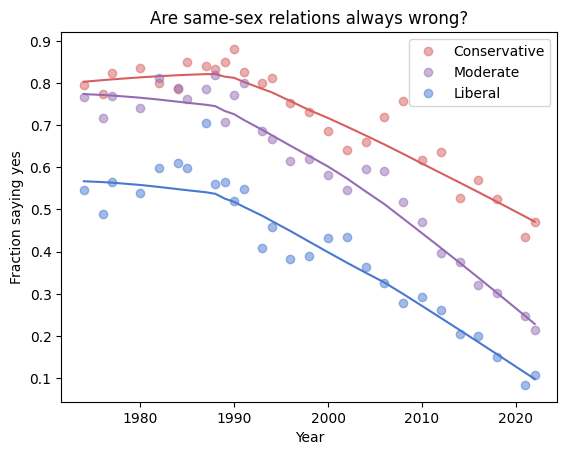

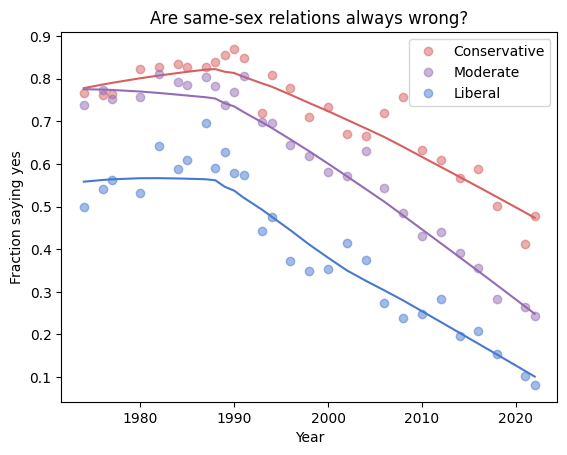

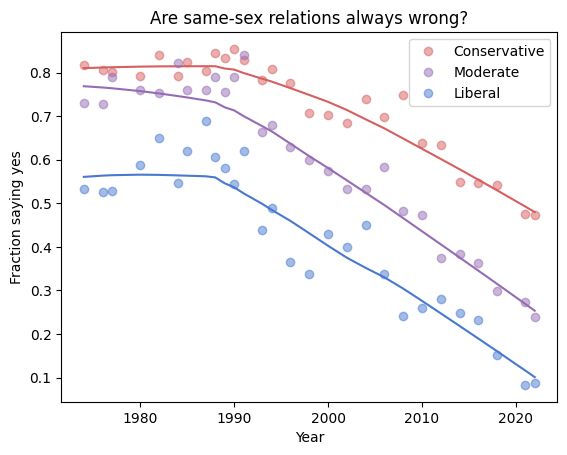

In [ ]:
datafile = "../data/gss_pacs_2022_resampled.hdf"

for key in ["gss0", "gss1", "gss2"]:
    df = pd.read_hdf(datafile, key)

    plt.figure()
    plot_by_polviews(df, varname)

You should review your interpretation in the previous section to see how it holds up to resampling. If you see an effect that is consistent in all three figures, it is less likely to be an artifact of random sampling.

If it varies from one resampling to the next, you should probably not take it too seriously.